# Word Prediction using Recurrent Neural Networks (RNNs)
## Experiment 2016-12-30

Experiment setup

### Table of Contents

1. Initialize
2. Prepare Data
3. Explore Data
4. Experiments

## 1. Initialize
### Import

In [150]:
# import python modules
from __future__ import print_function, division
import os.path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nltk import tokenize

In [151]:
# import wp modules (can be slow)
import sys; sys.path.append('../../src')
print('importing wp (and nltk)...')
import wp
print('done')

importing wp (and nltk)...
done


In [152]:
# reload wp modules in case changed (for development purposes)
reload(wp)
reload(wp.data)
reload(wp.util)
reload(wp.model)
reload(wp.ngram)
reload(wp.rnn)
reload(wp.experiment);

## 2. Prepare Data

Clean and merge raw text files, split into train, validate, and test sets.

In [153]:
# get wrapper around all data and tokenization
data = wp.data.Data('gutenbergs')

# clean, merge, split files
data.prepare()

Prepare dataset: gutenbergs
Clean raw files... done.
Merge cleaned files... done.
Split merged file... done.
Dataset ready.



In [154]:
# clean the raw data files - remove Gutenberg headers and footers, and non-ascii characters (nltk complains otherwise).
#data.clean()

# merge the cleaned data files into one.
#data.merge()

# split the merged file by sentences into train, validate, and test sets.
#data.split()

## 3. Explore Data

### Show some statistics

In [168]:
# slow
stats = data.analyze()
stats

,Text,Characters,Words,Sentences
0,1862 Victor Hugo Les Miserables,3213552,28456,35529
1,1865 Lewis Carroll Alice in Wonderland,148524,3117,1631
2,1883 Robert Louis Stevenson Treasure Island,360831,6624,3733
3,1898 Henry James The Turn of the Screw,226242,4810,2518
4,1899 Joseph Conrad Heart of Darkness,209176,5879,2432
5,1905 M R James Ghost Stories of an Antiquary,249247,6543,2190
6,1907 Arthur Machen The Hill of Dreams,363716,8172,2361
7,1908 Kenneth Graham The Wind in the Willows,321958,7448,3221
8,1919 P G Woodhouse My Man Jeeves,273859,5603,4671
9,1920 M R James A Thin Ghost and Others,165984,4581,1408


### Show sentence lengths

In [165]:
nsentences = 100
nwordsmax = 100
df = data.histogram(nsentences, nwordsmax)

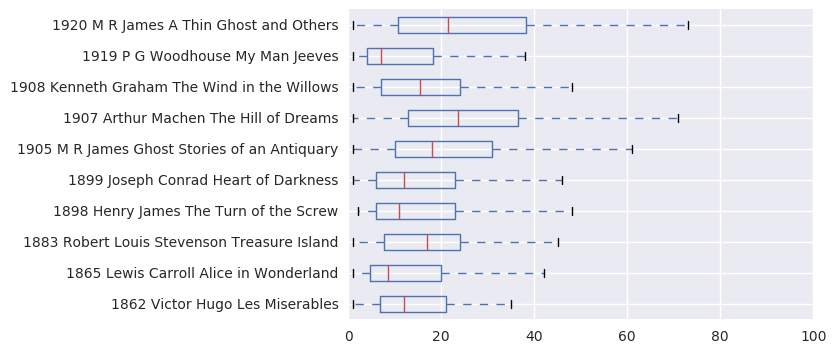

In [176]:
df.T.boxplot(vert=False);

In [177]:
#df.hist()
#plt.show()
#plt.figure(figsize=(12,7))
#plt.hist(lengths, range=(1,30), bins=30, stacked=True, label=filetitles, alpha=0.8, weights=weights)
#plt.legend(loc=(1.1,0.5))
#plt.grid()
#plt.subplots_adjust(left=0.01,right=0.5)
#plt.xlabel('Words')
#plt.ylabel('Amount')
#plt.show()

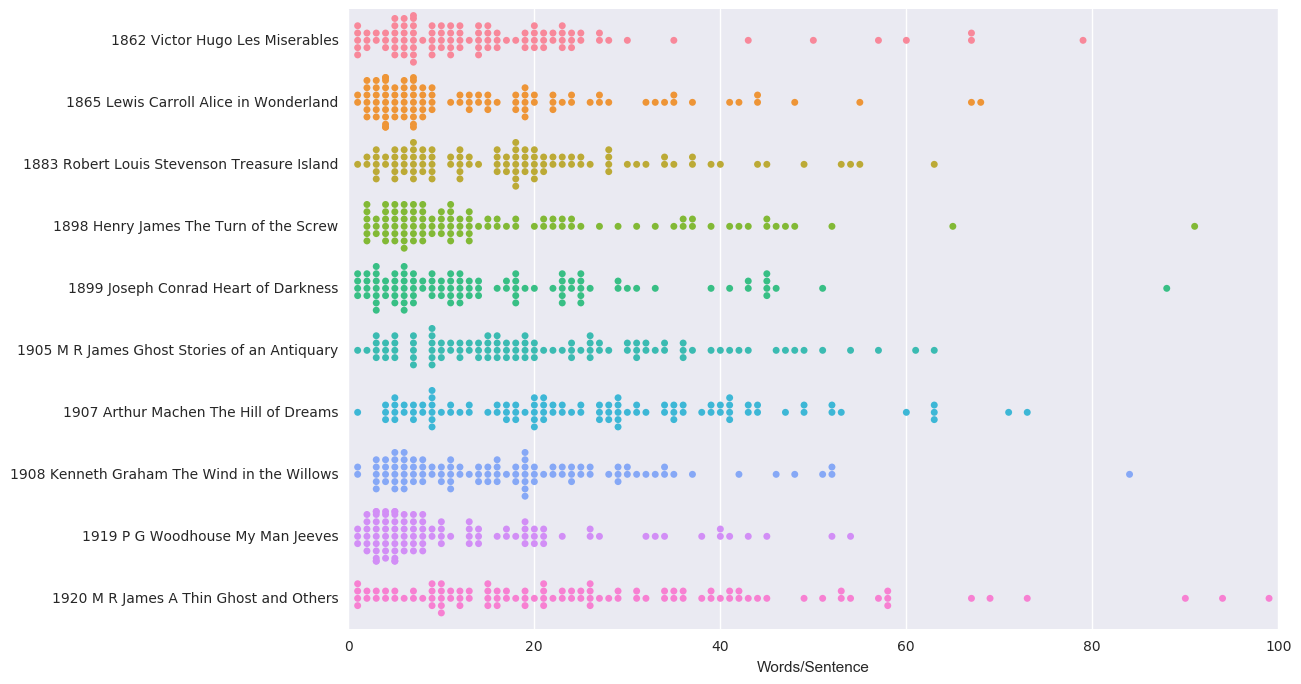

In [175]:
plt.figure(figsize=(12,8))
plt.xlabel('Words/Sentence')
plt.xlim([0, nwordsmax])
sns.swarmplot(data=df.T, orient='h', split=True);

In [162]:
stop

NameError: name 'stop' is not defined

### Show some samples of the text

In [ ]:
s_merged = data.text('merged')
nsamples = 4
nchars = len(s_merged)
nskip = int(nchars / nsamples)
for i in range(nsamples):
    s = s_merged[i*nskip:i*nskip+200]
    s = s.replace('\n', ' ').strip()
    print(s)
    print()

### Show some text split into sentences

This shows how the text was split up into the train, validate, and test sets.

In [ ]:
# we'll just look at the first 50k characters, because parsing sentences is slow
sentences = data.sentences('merged', 50000)
random.seed(2)
samples = random.sample(sentences, 4)
print('\n\n'.join(samples))

### Show the text split into tokens

Note that punctuation marks are treated as separate tokens.

In [ ]:
tokens = data.tokens('merged', 50000)
print('ntokens',len(tokens))
print(tokens[-50:])

## 4. Experiments

Conduct some experiments

### 4.1 Test models on some test data

After preparing the 6mb of Gutenberg data, let's test out the models with a much smaller dataset first.

In [ ]:
data = wp.data.Data('animals')
data.text()

In [ ]:
# define models to train and test
model_specs = [
    [wp.ngram.Ngram, {'n':1}],
    [wp.ngram.Ngram, {'n':2}],
    [wp.ngram.Ngram, {'n':3}],
    [wp.ngram.Ngram, {'n':4}],
    [wp.rnn.Rnn, {'nvocabmax':10,'nhidden':10}],
]

In [ ]:
# create experiment
params = {'train_amount':[0.5, 1.0]}
exper = wp.experiment.Experiment(model_specs, data, params)

In [ ]:
# run it
exper.run()

Plot the results

### 4.2 Compare n-gram performance

In [ ]:
# define models to train and test
model_specs = [
    [wp.ngram.Ngram, {'n':1}],
    [wp.ngram.Ngram, {'n':2}],
    [wp.ngram.Ngram, {'n':3}],
    [wp.ngram.Ngram, {'n':4}],
    [wp.rnn.Rnn, {'nvocabmax':1000,'nhidden':100}],
    [wp.rnn.Rnn, {'nvocabmax':10,'nhidden':10}],
]

In [ ]:
# train models on different amounts of training data

train_amounts = [0.0001, 0.001, 0.01, 0.1, 1.0] # fraction of total training data

#nchars_list = [1000]#,10000,100000]#,1000000,6000000]
model_table = wp.analyze.init_model_table(model_specs, data, nchars_list)
print('done')

## 5. Test Models

Test all models on held-out test data.

In [ ]:
# test all models and save results to a pandas dataframe

ntest_chars = 10000
npredictions_max = 1000
k = 3 # predict top k tokens

df = wp.analyze.test_model_table(model_table, data, ntest_chars, npredictions_max, k)

In [ ]:
df

In [ ]:
for i in range(len(df.index)):
    ix_i = df.ix[i]
    plt.plot(df.columns, ix_i)
plt.legend(loc=(1.1,0.5))
plt.xscale('log')
plt.xlabel('Training set size (chars)')
plt.ylabel('Accuracy')
plt.show()

## 6. Generate Text

In [ ]:
nsentences = 5
models = model_table[-1] # use models with most training data
for model in models[1:]:
    print(model.name)
    print('-'*80)
    for seed in range(nsentences):
        random.seed(seed)
        s = model.generate()
        print(s)
        print()
    print()